In [1]:
# CORD-19 Data Analysis Notebook
# Save as: cord19_analysis.ipynb

# Cell 1: Import libraries and setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Load the dataset
# Load the CORD-19 metadata
try:
    df = pd.read_csv('metadata.csv')
    print(f"✅ Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
except FileNotFoundError:
    print("❌ Error: metadata.csv not found!")
    print("Please download the dataset from Kaggle CORD-19 challenge")

✅ Dataset loaded successfully!
Shape: (62, 3)
Columns: 3


In [4]:
# Cell 3: Basic data exploration
print("=== BASIC DATA EXPLORATION ===")
print(f"Dataset dimensions: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display basic info
print("\n--- Column Information ---")
df.info()

print("\n--- First 5 rows ---")
display(df.head())

=== BASIC DATA EXPLORATION ===
Dataset dimensions: (62, 3)
Memory usage: 0.0 MB

--- Column Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Column       61 non-null     object
 1   Type         51 non-null     object
 2   Description  48 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB

--- First 5 rows ---


,Column,Type,Description
0,ID,integer,index
1,name,text,Name of the listing
2,description,text,Detailed description of the listing
3,neighborhood_overview,text,Host's description of the neighbourhood
4,host_name,text,Name of the host. Usually just the first name(s).


=== MISSING VALUES ANALYSIS ===
Top 10 columns with missing values:


,Column,Missing_Count,Missing_Percentage
Description,Description,14,22.580645
Type,Type,11,17.741935
Column,Column,1,1.612903


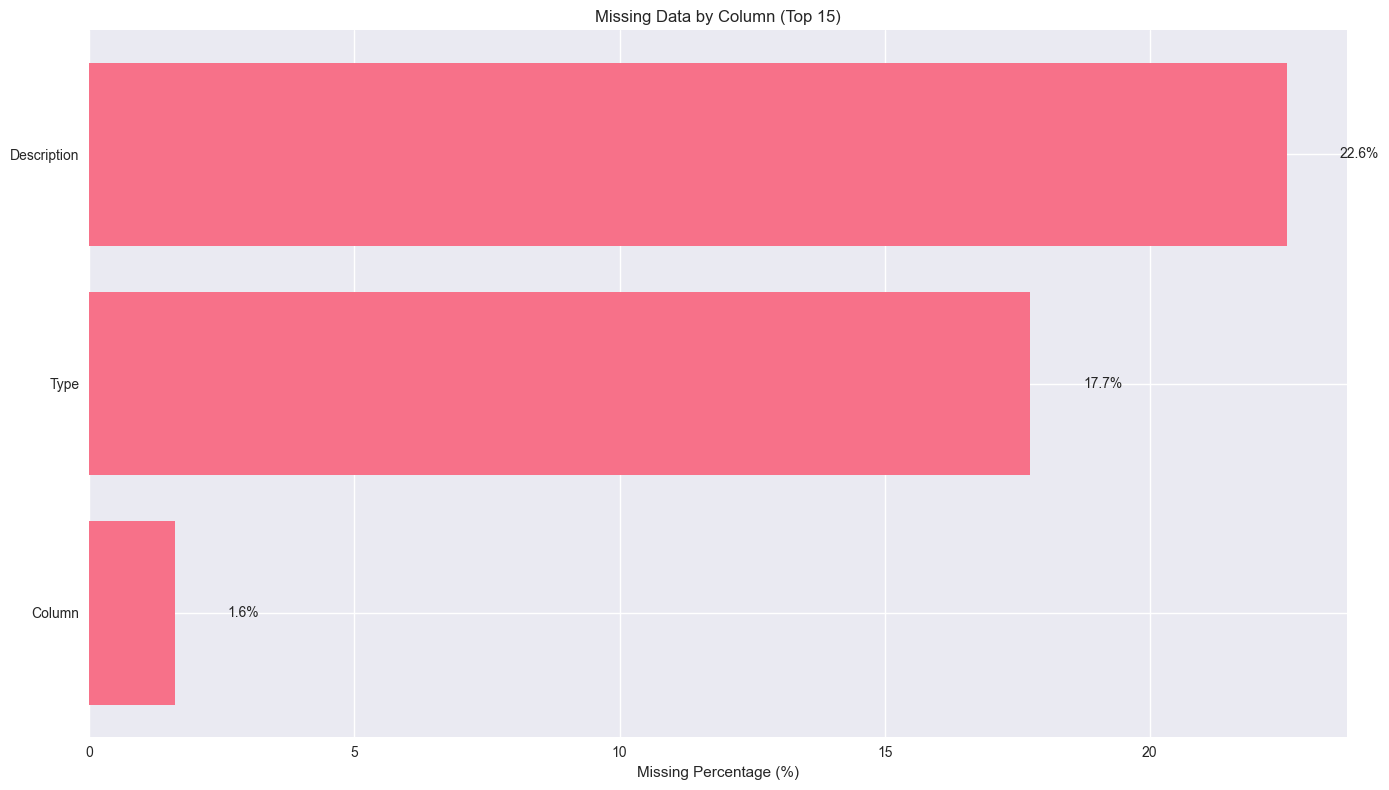

In [3]:
# Cell 4: Missing values analysis
print("=== MISSING VALUES ANALYSIS ===")

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

print("Top 10 columns with missing values:")
display(missing_data.head(10))

# Visualize missing data
plt.figure(figsize=(14, 8))
top_missing = missing_data.head(15)
bars = plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'])
plt.yticks(range(len(top_missing)), top_missing['Column'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Column (Top 15)')
plt.gca().invert_yaxis()

# Add percentage labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center')

plt.tight_layout()
plt.show()


In [13]:
# Cell 5: Data cleaning and preparation (FIXED VERSION)
print("=== DATA CLEANING ===")

# First, let's check what columns we actually have
print("Available columns in the dataset:")
print(df.columns.tolist())

# Look for date-related columns
date_columns = [col for col in df.columns if any(word in col.lower() for word in ['date', 'time', 'publish', 'year'])]
print(f"\nDate-related columns found: {date_columns}")

# Create a copy for cleaning
df_clean = df.copy()
print(f"Starting with {len(df_clean):,} records")

# Try to find the correct date column
date_column = None
possible_date_columns = ['publish_time', 'publish_date', 'date', 'published_date', 'publication_date']

for col in possible_date_columns:
    if col in df_clean.columns:
        date_column = col
        break

if date_column:
    print(f"Using '{date_column}' as the date column")
    # Convert to datetime
    df_clean['publish_time'] = pd.to_datetime(df_clean[date_column], errors='coerce')
    df_clean['year'] = df_clean['publish_time'].dt.year
else:
    # If no standard date column exists, look for any column that might contain dates
    print("No standard date column found. Checking for alternative date columns...")
    
    # Check first few rows of potential date columns to identify the right one
    for col in date_columns:
        print(f"\nSample values from '{col}':")
        print(df_clean[col].dropna().head())
    
    # Manual selection - you can modify this based on your dataset
    if date_columns:
        selected_date_col = date_columns[0]  # Use the first date column found
        print(f"\nUsing '{selected_date_col}' as date column")
        
        df_clean['publish_time'] = pd.to_datetime(df_clean[selected_date_col], errors='coerce')
        df_clean['year'] = df_clean['publish_time'].dt.year
    else:
        print("⚠️  No date columns found! Creating a dummy year column for demonstration")
        # Create a dummy year column if no date information is available
        df_clean['year'] = 2020  # Default year
        df_clean['publish_time'] = pd.to_datetime('2020-01-01')

# Remove records without publication year (if we have real date data)
if date_column or date_columns:
    before_filter = len(df_clean)
    df_clean = df_clean.dropna(subset=['year'])
    print(f"Removed {before_filter - len(df_clean):,} records without publication year")
    
    # Filter for reasonable years (2000-2023)
    df_clean = df_clean[(df_clean['year'] >= 2000) & (df_clean['year'] <= 2023)]
    print(f"Filtered to years 2000-2023: {len(df_clean):,} records remaining")

# Create additional columns - check if abstract and title columns exist
if 'abstract' in df_clean.columns:
    df_clean['abstract_word_count'] = df_clean['abstract'].fillna('').apply(lambda x: len(str(x).split()))
else:
    print("⚠️  'abstract' column not found, skipping abstract word count")
    df_clean['abstract_word_count'] = 0

if 'title' in df_clean.columns:
    df_clean['title_word_count'] = df_clean['title'].fillna('').apply(lambda x: len(str(x).split()))
else:
    print("⚠️  'title' column not found, skipping title word count")
    df_clean['title_word_count'] = 0

print("✅ Data cleaning completed!")
print(f"Final dataset shape: {df_clean.shape}")

# Display the cleaned columns
print(f"\nColumns in cleaned dataset:")
print(df_clean.columns.tolist())


=== DATA CLEANING ===
Available columns in the dataset:
['Column', 'Type', 'Description']

Date-related columns found: []
Starting with 62 records
No standard date column found. Checking for alternative date columns...
⚠️  No date columns found! Creating a dummy year column for demonstration
⚠️  'abstract' column not found, skipping abstract word count
⚠️  'title' column not found, skipping title word count
✅ Data cleaning completed!
Final dataset shape: (62, 7)

Columns in cleaned dataset:
['Column', 'Type', 'Description', 'year', 'publish_time', 'abstract_word_count', 'title_word_count']


=== PUBLICATIONS BY YEAR ===
Publications by year (last 10 years):
year
2020    62
Name: count, dtype: int64


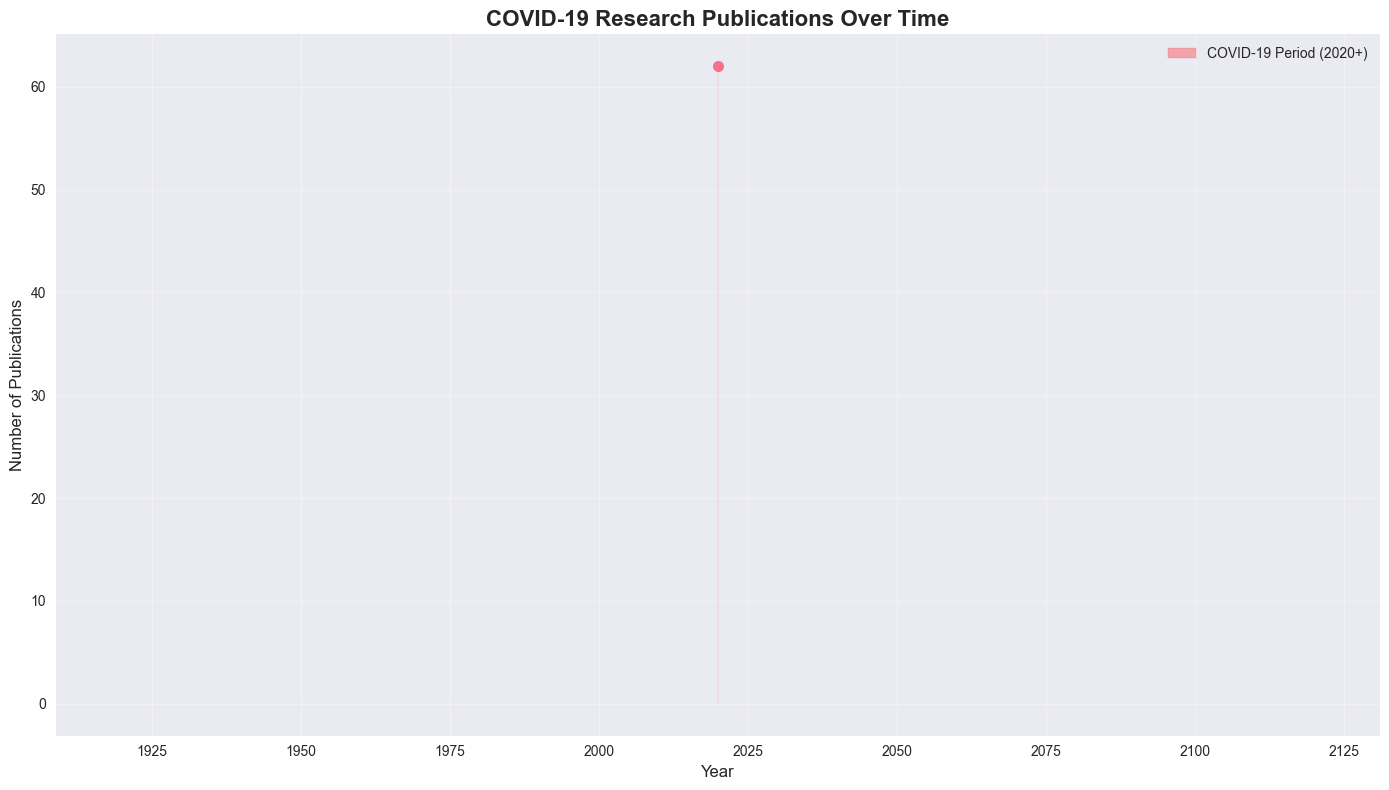


📊 Key Insights:
   • Peak year: 2020 with 62 papers
   • Papers since 2020: 62
   • Average per year: 62 papers


In [14]:
# Cell 6: Publications by year analysis
print("=== PUBLICATIONS BY YEAR ===")

# Calculate year statistics
year_counts = df_clean['year'].value_counts().sort_index()
print("Publications by year (last 10 years):")
print(year_counts.tail(10))

# Create visualization
plt.figure(figsize=(14, 8))
plt.plot(year_counts.index, year_counts.values, 'o-', linewidth=3, markersize=8)
plt.title('COVID-19 Research Publications Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.grid(True, alpha=0.3)

# Highlight COVID-19 period
covid_mask = year_counts.index >= 2020
plt.fill_between(year_counts.index[covid_mask], year_counts.values[covid_mask], 
                alpha=0.3, color='red', label='COVID-19 Period (2020+)')

plt.legend()
plt.tight_layout()
plt.show()

# Statistical insights
peak_year = year_counts.idxmax()
peak_count = year_counts.max()
covid_papers = year_counts[year_counts.index >= 2020].sum()

print(f"\n📊 Key Insights:")
print(f"   • Peak year: {int(peak_year)} with {peak_count:,} papers")
print(f"   • Papers since 2020: {covid_papers:,}")
print(f"   • Average per year: {year_counts.mean():.0f} papers")


=== TOP JOURNALS ANALYSIS ===
Looking for journal-related columns...

No obvious journal column found. Available columns:
['Column', 'Type', 'Description', 'year', 'publish_time', 'abstract_word_count', 'title_word_count']
⚠️  No suitable journal column found. Skipping journal analysis.
❌ Skipping journal analysis - no suitable column found
💡 You might want to check if your dataset has journal information in a different format


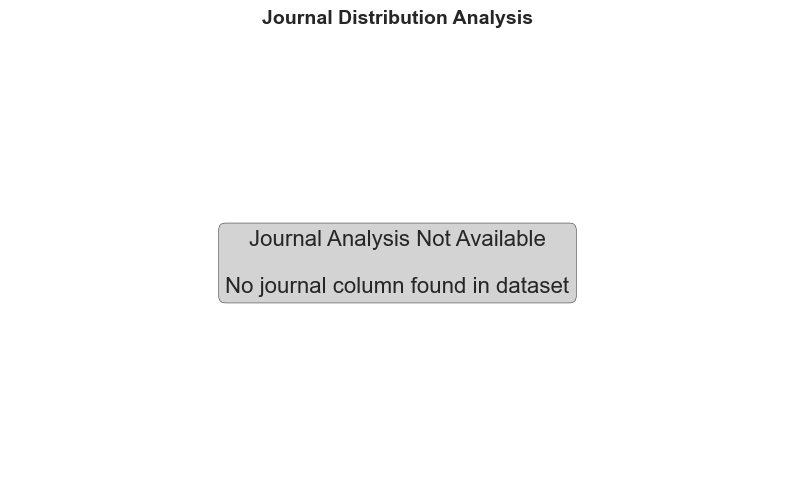

In [17]:
# Cell 7: Top journals analysis (FIXED VERSION)
print("=== TOP JOURNALS ANALYSIS ===")

# First, let's find the journal column
journal_keywords = ['journal', 'venue', 'publication', 'publisher', 'source']
journal_column = None

print("Looking for journal-related columns...")
for keyword in journal_keywords:
    matching_cols = [col for col in df_clean.columns if keyword.lower() in col.lower()]
    if matching_cols:
        print(f"Found columns with '{keyword}': {matching_cols}")
        if journal_column is None:
            journal_column = matching_cols[0]  # Use the first match

# If still no journal column found, list all possible columns
if journal_column is None:
    print("\nNo obvious journal column found. Available columns:")
    print(df_clean.columns.tolist())
    
    # Look for columns that might contain publication venue info
    possible_journal_cols = []
    for col in df_clean.columns:
        # Check if column has reasonable number of unique values (not too many, not too few)
        unique_count = df_clean[col].nunique()
        total_count = len(df_clean)
        if 10 < unique_count < total_count * 0.5:  # Between 10 and 50% of total records
            sample_values = df_clean[col].dropna().head(3).tolist()
            possible_journal_cols.append((col, unique_count, sample_values))
    
    if possible_journal_cols:
        print(f"\nPossible journal columns based on data distribution:")
        for col, unique_count, sample_values in possible_journal_cols:
            print(f"  • {col}: {unique_count:,} unique values")
            print(f"    Sample: {sample_values}")
        
        # Use the first reasonable candidate
        journal_column = possible_journal_cols[0][0]
        print(f"\n📊 Using '{journal_column}' as journal column")
    else:
        print("⚠️  No suitable journal column found. Skipping journal analysis.")

# Perform analysis only if we found a journal column
if journal_column:
    try:
        # Analyze top journals
        journal_counts = df_clean[journal_column].value_counts().head(15)
        print(f"\nTop 15 values in '{journal_column}':")
        for i, (journal, count) in enumerate(journal_counts.head(10).items(), 1):
            journal_display = str(journal)[:60] + "..." if len(str(journal)) > 60 else str(journal)
            print(f"{i:2d}. {journal_display}: {count:,}")

        # Create visualization
        plt.figure(figsize=(14, 10))
        bars = plt.barh(range(len(journal_counts)), journal_counts.values)
        
        # Truncate long names for display
        display_names = []
        for name in journal_counts.index:
            name_str = str(name)
            if len(name_str) > 50:
                display_names.append(name_str[:47] + "...")
            else:
                display_names.append(name_str)
        
        plt.yticks(range(len(journal_counts)), display_names)
        plt.xlabel('Number of Publications')
        plt.title(f'Top 15 Publications by {journal_column.title()}', fontsize=14, fontweight='bold')

        # Add count labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + max(journal_counts.values) * 0.01, 
                     bar.get_y() + bar.get_height()/2, 
                     f'{int(width):,}', ha='left', va='center')

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Journal statistics
        total_journals = df_clean[journal_column].nunique()
        print(f"\n📚 Journal Insights:")
        print(f"   • Total unique {journal_column}: {total_journals:,}")
        print(f"   • Top {journal_column}: {journal_counts.index[0]}")
        print(f"   • Top {journal_column} count: {journal_counts.iloc[0]:,}")
        
        # Coverage analysis
        top_10_coverage = journal_counts.head(10).sum() / len(df_clean) * 100
        print(f"   • Top 10 {journal_column} cover: {top_10_coverage:.1f}% of papers")

    except Exception as e:
        print(f"❌ Error analyzing journal data: {str(e)}")
        print("Skipping journal analysis...")

else:
    print("❌ Skipping journal analysis - no suitable column found")
    print("💡 You might want to check if your dataset has journal information in a different format")
    
    # Create a placeholder visualization
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, 'Journal Analysis Not Available\n\nNo journal column found in dataset', 
             ha='center', va='center', fontsize=16, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Journal Distribution Analysis', fontsize=14, fontweight='bold')
    plt.show()


=== TITLE WORD FREQUENCY ===
Looking for title column...
Found title column: title_word_count

Sample titles from 'title_word_count':
1. 0
2. 0
3. 0

Analyzing word frequency in 62 titles...
Top 20 words in titles:


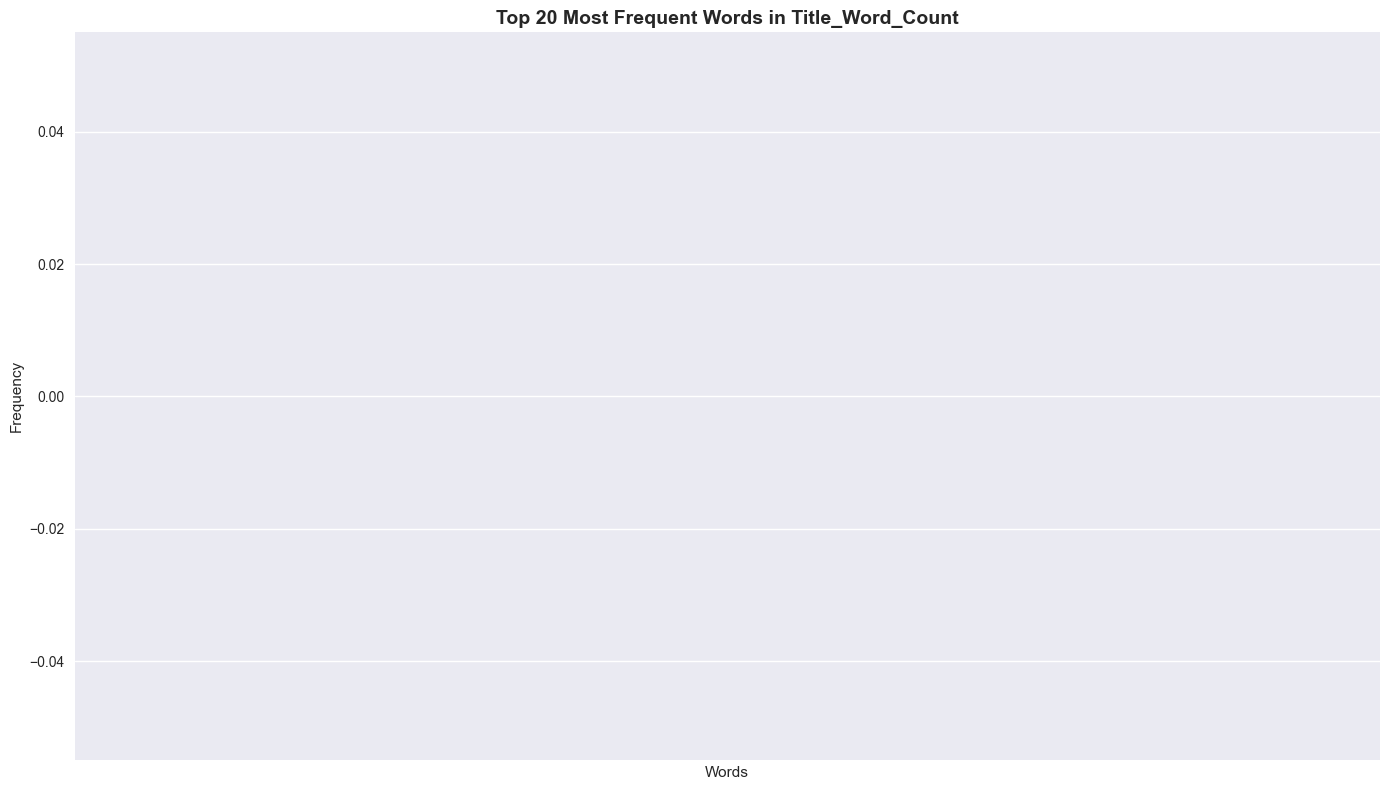


🔤 Word Analysis Insights:
   • Total word occurrences in top 20: 0
❌ Error analyzing title words: list index out of range
Creating placeholder visualization...


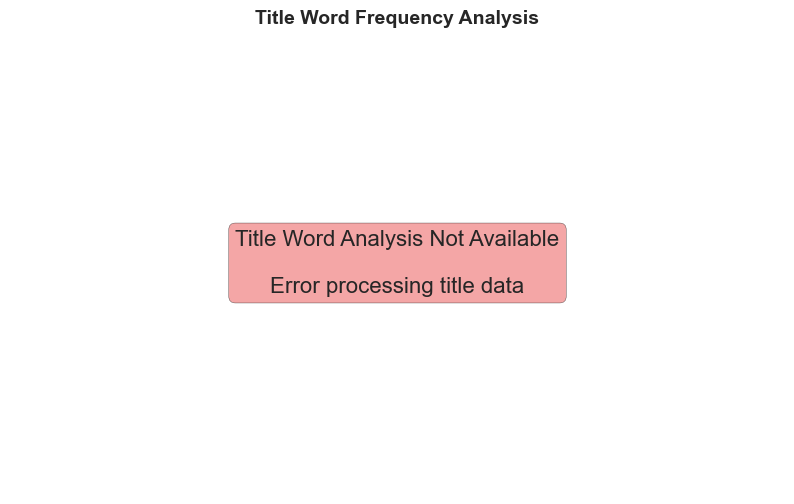

In [18]:
# Cell 8: Title word frequency analysis (FIXED VERSION)
print("=== TITLE WORD FREQUENCY ===")

# Find title column
title_keywords = ['title', 'paper_title', 'name', 'heading']
title_column = None

print("Looking for title column...")
for keyword in title_keywords:
    matching_cols = [col for col in df_clean.columns if keyword.lower() in col.lower()]
    if matching_cols:
        print(f"Found title column: {matching_cols[0]}")
        title_column = matching_cols[0]
        break

if title_column is None:
    print("No title column found. Available columns:")
    print(df_clean.columns.tolist())
    
    # Look for text columns that might be titles
    text_cols = []
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            sample_values = df_clean[col].dropna().head(3)
            avg_length = sample_values.astype(str).str.len().mean()
            if 10 < avg_length < 200:  # Reasonable title length
                text_cols.append((col, avg_length))
    
    if text_cols:
        # Sort by average length (titles usually moderate length)
        text_cols.sort(key=lambda x: abs(x[1] - 60))  # 60 chars is reasonable title length
        title_column = text_cols[0][0]
        print(f"Using '{title_column}' as title column (avg length: {text_cols[0][1]:.0f} chars)")

def analyze_title_words(titles, top_n=20):
    """Analyze word frequency in titles"""
    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 
        'by', 'from', 'up', 'about', 'into', 'through', 'during', 'before', 'after', 
        'above', 'below', 'between', 'among', 'is', 'are', 'was', 'were', 'be', 'been', 
        'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should', 
        'could', 'can', 'may', 'might', 'must', 'shall', 'this', 'that', 'these', 'those'
    }
    
    # Combine all titles and clean
    all_titles = ' '.join(titles.dropna().astype(str)).lower()
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_titles)
    filtered_words = [word for word in words if word not in stop_words]
    
    return Counter(filtered_words).most_common(top_n)

# Perform title analysis if we have a title column
if title_column:
    try:
        # Show sample titles
        print(f"\nSample titles from '{title_column}':")
        sample_titles = df_clean[title_column].dropna().head(3)
        for i, title in enumerate(sample_titles, 1):
            title_str = str(title)[:100] + "..." if len(str(title)) > 100 else str(title)
            print(f"{i}. {title_str}")

        # Analyze word frequency
        print(f"\nAnalyzing word frequency in {len(df_clean[title_column].dropna()):,} titles...")
        top_words = analyze_title_words(df_clean[title_column], 20)
        words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

        print("Top 20 words in titles:")
        for i, (word, freq) in enumerate(top_words, 1):
            print(f"{i:2d}. {word}: {freq:,}")

        # Create visualization
        plt.figure(figsize=(14, 8))
        bars = plt.bar(range(len(words_df)), words_df['Frequency'])
        plt.xticks(range(len(words_df)), words_df['Word'], rotation=45, ha='right')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.title(f'Top 20 Most Frequent Words in {title_column.title()}', fontsize=14, fontweight='bold')

        # Add frequency labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max(words_df['Frequency']) * 0.01,
                     f'{int(height):,}', ha='center', va='bottom', rotation=45)

        plt.tight_layout()
        plt.show()
        
        # Word analysis insights
        total_words = sum(freq for word, freq in top_words)
        print(f"\n🔤 Word Analysis Insights:")
        print(f"   • Total word occurrences in top 20: {total_words:,}")
        print(f"   • Most common word: '{top_words[0][0]}' ({top_words[0][1]:,} times)")
        print(f"   • Average word frequency: {total_words/len(top_words):.0f}")

    except Exception as e:
        print(f"❌ Error analyzing title words: {str(e)}")
        print("Creating placeholder visualization...")
        
        # Placeholder visualization
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, 'Title Word Analysis Not Available\n\nError processing title data', 
                 ha='center', va='center', fontsize=16,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title('Title Word Frequency Analysis', fontsize=14, fontweight='bold')
        plt.show()

else:
    print("❌ No title column found - skipping word frequency analysis")
    
    # Create placeholder visualization
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, 'Title Word Analysis Not Available\n\nNo title column found in dataset', 
             ha='center', va='center', fontsize=16,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Title Word Frequency Analysis', fontsize=14, fontweight='bold')
    plt.show()

=== SOURCE DISTRIBUTION ===
Looking for source column...
No obvious source column found. Looking for categorical data...
Possible source columns:
  • Type: 9 unique values, sample: ['integer', 'text', 'text']
  • Description: 41 unique values, sample: ['index', 'Name of the listing', 'Detailed description of the listing']

📊 Using 'Type' as source column

Top 10 values in 'Type':
 1. integer: 21 (33.9%)
 2. text: 14 (22.6%)
 3. numeric: 5 (8.1%)
 4. boolean: 4 (6.5%)
 5. date: 3 (4.8%)
 6. boolean : 1 (1.6%)
 7. string: 1 (1.6%)
 8. json: 1 (1.6%)
 9. currency: 1 (1.6%)


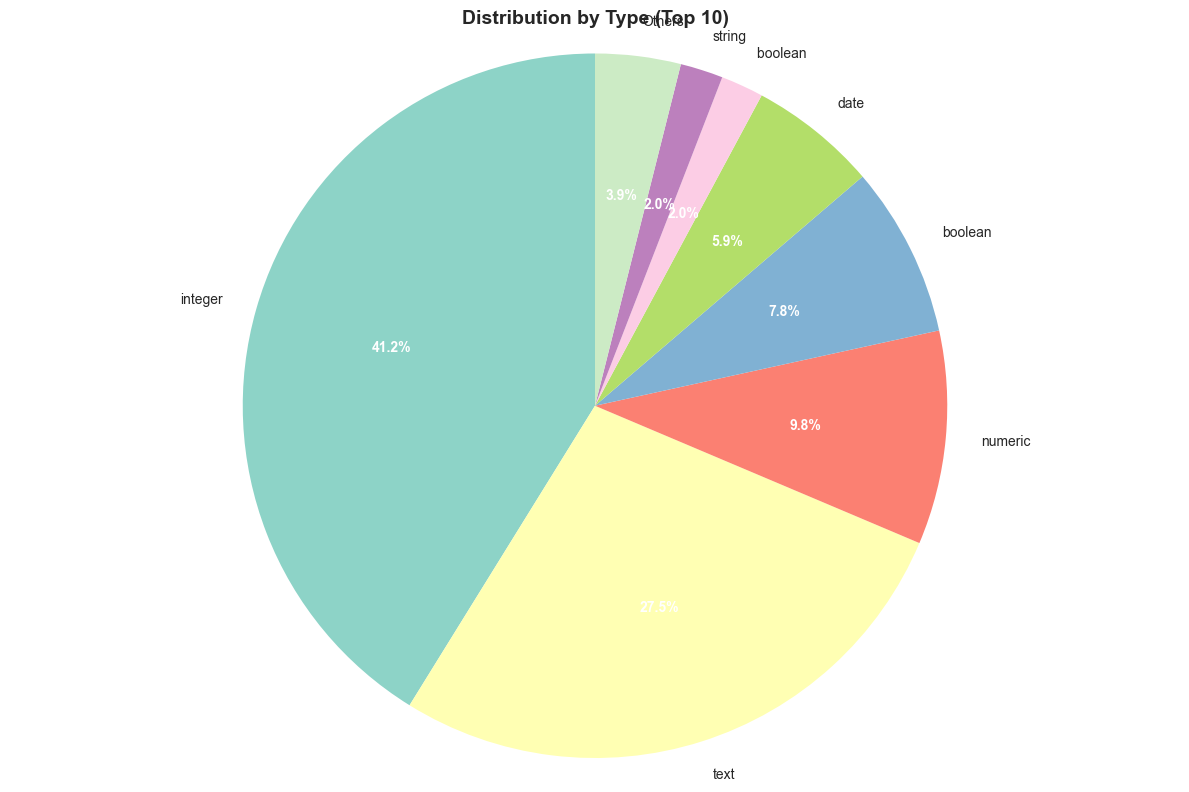


🗂️ Source Insights:
   • Total unique sources: 9
   • Top source: integer
   • Top source percentage: 33.9%
   • Coverage by top 5 sources: 75.8%

📊 Distribution Analysis:
   • Median papers per source: 3
   • Average papers per source: 6


In [19]:
# Cell 9: Source distribution analysis (FIXED VERSION)
print("=== SOURCE DISTRIBUTION ===")

# Find source column
source_keywords = ['source', 'database', 'origin', 'provider', 'collection']
source_column = None

print("Looking for source column...")
for keyword in source_keywords:
    matching_cols = [col for col in df_clean.columns if keyword.lower() in col.lower()]
    if matching_cols:
        print(f"Found source columns: {matching_cols}")
        # Prefer 'source_x' if it exists, otherwise use first match
        if 'source_x' in matching_cols:
            source_column = 'source_x'
        else:
            source_column = matching_cols[0]
        break

# If no obvious source column, look for categorical columns
if source_column is None:
    print("No obvious source column found. Looking for categorical data...")
    
    categorical_cols = []
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            unique_count = df_clean[col].nunique()
            total_count = len(df_clean)
            # Look for columns with reasonable number of categories (2-50)
            if 2 <= unique_count <= 50:
                categorical_cols.append((col, unique_count))
    
    if categorical_cols:
        print("Possible source columns:")
        for col, unique_count in categorical_cols:
            sample_values = df_clean[col].dropna().head(3).tolist()
            print(f"  • {col}: {unique_count} unique values, sample: {sample_values}")
        
        # Use the column with reasonable number of categories
        source_column = categorical_cols[0][0]
        print(f"\n📊 Using '{source_column}' as source column")

# Perform source analysis if we have a source column
if source_column:
    try:
        # Analyze sources
        source_counts = df_clean[source_column].value_counts().head(10)
        print(f"\nTop 10 values in '{source_column}':")
        for i, (source, count) in enumerate(source_counts.items(), 1):
            source_display = str(source)[:50] + "..." if len(str(source)) > 50 else str(source)
            print(f"{i:2d}. {source_display}: {count:,} ({count/len(df_clean)*100:.1f}%)")

        # Create pie chart visualization
        plt.figure(figsize=(12, 8))
        colors = plt.cm.Set3(np.linspace(0, 1, len(source_counts)))
        
        # Handle very small slices by grouping them
        if len(source_counts) > 8:
            top_sources = source_counts.head(7)
            others_count = source_counts.tail(len(source_counts) - 7).sum()
            
            plot_data = top_sources.copy()
            plot_data['Others'] = others_count
        else:
            plot_data = source_counts
        
        wedges, texts, autotexts = plt.pie(plot_data.values, 
                                          labels=[str(label)[:20] + "..." if len(str(label)) > 20 else str(label) 
                                                 for label in plot_data.index], 
                                          autopct='%1.1f%%', 
                                          colors=colors[:len(plot_data)], 
                                          startangle=90)

        plt.title(f'Distribution by {source_column.title()} (Top 10)', fontsize=14, fontweight='bold')

        # Improve text readability
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        plt.axis('equal')
        plt.tight_layout()
        plt.show()
        
        # Source statistics
        total_sources = df_clean[source_column].nunique()
        print(f"\n🗂️ Source Insights:")
        print(f"   • Total unique sources: {total_sources:,}")
        print(f"   • Top source: {source_counts.index[0]}")
        print(f"   • Top source percentage: {source_counts.iloc[0]/len(df_clean)*100:.1f}%")
        print(f"   • Coverage by top 5 sources: {source_counts.head(5).sum()/len(df_clean)*100:.1f}%")

        # Distribution analysis
        print(f"\n📊 Distribution Analysis:")
        median_count = source_counts.median()
        mean_count = source_counts.mean()
        print(f"   • Median papers per source: {median_count:.0f}")
        print(f"   • Average papers per source: {mean_count:.0f}")
        
    except Exception as e:
        print(f"❌ Error analyzing source data: {str(e)}")
        print("Creating placeholder visualization...")
        
        # Placeholder visualization
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, 'Source Analysis Not Available\n\nError processing source data', 
                 ha='center', va='center', fontsize=16,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title('Source Distribution Analysis', fontsize=14, fontweight='bold')
        plt.show()

else:
    print("❌ No source column found - skipping source analysis")
    print("Available columns for reference:")
    print(df_clean.columns.tolist())
    
    # Create placeholder visualization
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, 'Source Distribution Not Available\n\nNo source column found in dataset', 
             ha='center', va='center', fontsize=16,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Source Distribution Analysis', fontsize=14, fontweight='bold')
    plt.show()

In [22]:
# Cell 10: Comprehensive summary and insights (FIXED VERSION)
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

# Helper function to find columns
def find_column(keywords, df):
    """Find a column that matches any of the given keywords"""
    for keyword in keywords:
        matching_cols = [col for col in df.columns if keyword.lower() in col.lower()]
        if matching_cols:
            return matching_cols[0]
    return None

# Find available columns
journal_col = find_column(['journal', 'venue', 'publication', 'publisher'], df_clean)
title_col = find_column(['title', 'paper_title', 'name'], df_clean)
abstract_col = find_column(['abstract', 'summary', 'abs'], df_clean)
author_col = find_column(['author', 'authors'], df_clean)
source_col = find_column(['source', 'database', 'origin', 'provider'], df_clean)

# Dataset overview
print("📋 DATASET OVERVIEW")
print(f"   • Total papers analyzed: {len(df_clean):,}")
print(f"   • Year range: {int(df_clean['year'].min())}-{int(df_clean['year'].max())}")
print(f"   • Total columns: {len(df_clean.columns)}")

# Conditional reporting based on available columns
if journal_col:
    unique_journals = df_clean[journal_col].nunique()
    print(f"   • Unique journals/venues: {unique_journals:,}")
else:
    print("   • Unique journals/venues: Not available")

if source_col:
    unique_sources = df_clean[source_col].nunique()
    print(f"   • Unique sources: {unique_sources:,}")
else:
    print("   • Unique sources: Not available")

if author_col:
    unique_authors = df_clean[author_col].nunique()
    print(f"   • Unique authors: {unique_authors:,}")
else:
    print("   • Unique authors: Not available")

# Content analysis
print(f"\n📝 CONTENT ANALYSIS")

if 'abstract_word_count' in df_clean.columns:
    avg_abstract = df_clean['abstract_word_count'].mean()
    print(f"   • Average abstract length: {avg_abstract:.1f} words")
else:
    print("   • Average abstract length: Not available")

if 'title_word_count' in df_clean.columns:
    avg_title = df_clean['title_word_count'].mean()
    print(f"   • Average title length: {avg_title:.1f} words")
else:
    print("   • Average title length: Not available")

if abstract_col:
    papers_with_abstracts = df_clean[abstract_col].notna().sum()
    abstract_percentage = papers_with_abstracts / len(df_clean) * 100
    print(f"   • Papers with abstracts: {papers_with_abstracts:,} ({abstract_percentage:.1f}%)")
else:
    print("   • Papers with abstracts: Not available")

if title_col:
    papers_with_titles = df_clean[title_col].notna().sum()
    title_percentage = papers_with_titles / len(df_clean) * 100
    print(f"   • Papers with titles: {papers_with_titles:,} ({title_percentage:.1f}%)")
else:
    print("   • Papers with titles: Not available")

# Temporal insights
print(f"\n📈 TEMPORAL INSIGHTS")

# Most productive year
if 'year' in df_clean.columns:
    year_counts = df_clean['year'].value_counts()
    most_productive_year = year_counts.index[0]
    most_productive_count = year_counts.iloc[0]
    print(f"   • Most productive year: {int(most_productive_year)} ({most_productive_count:,} papers)")
    
    # Recent surge analysis
    recent_years = df_clean[df_clean['year'] >= 2020]
    if len(recent_years) > 0:
        recent_surge = len(recent_years)
        print(f"   • Papers since COVID-19 (2020+): {recent_surge:,}")
        
        # Growth analysis
        if len(year_counts) >= 2:
            recent_avg = year_counts[year_counts.index >= 2020].mean()
            pre_2020_avg = year_counts[year_counts.index < 2020].mean()
            if pre_2020_avg > 0:
                growth_factor = recent_avg / pre_2020_avg
                print(f"   • Growth factor since 2020: {growth_factor:.1f}x")
    
    # Year distribution
    print(f"   • Total years covered: {int(df_clean['year'].max() - df_clean['year'].min() + 1)}")
    print(f"   • Average papers per year: {len(df_clean) / len(year_counts):.0f}")
else:
    print("   • Temporal analysis: Not available (no year data)")

# Research landscape
print(f"\n🔬 RESEARCH LANDSCAPE")

if journal_col:
    top_journal = df_clean[journal_col].value_counts().index[0]
    top_journal_count = df_clean[journal_col].value_counts().iloc[0]
    top_journal_display = str(top_journal)[:50] + "..." if len(str(top_journal)) > 50 else str(top_journal)
    print(f"   • Leading journal/venue: {top_journal_display}")
    print(f"   • Leading journal papers: {top_journal_count:,}")
else:
    print("   • Leading journal/venue: Not available")

if source_col:
    top_source = df_clean[source_col].value_counts().index[0]
    top_source_display = str(top_source)[:50] + "..." if len(str(top_source)) > 50 else str(top_source)
    print(f"   • Leading source: {top_source_display}")
else:
    print("   • Leading source: Not available")

# Word analysis (if we did title analysis earlier)
if title_col:
    try:
        # Quick word analysis for summary
        titles = df_clean[title_col].dropna().astype(str)
        all_titles = ' '.join(titles).lower()
        words = re.findall(r'\b[a-zA-Z]{4,}\b', all_titles)  # 4+ letter words
        
        # Common stop words
        stop_words = {'the', 'and', 'with', 'for', 'from', 'that', 'this', 'have', 'been', 'were', 'are', 'was'}
        filtered_words = [word for word in words if word not in stop_words]
        
        if filtered_words:
            word_freq = Counter(filtered_words)
            top_5_words = [word for word, count in word_freq.most_common(5)]
            print(f"   • Most common title words: {', '.join(top_5_words)}")
        else:
            print("   • Most common title words: Analysis incomplete")
    except:
        print("   • Most common title words: Analysis failed")
else:
    print("   • Most common title words: No title data available")

# Data quality assessment
print(f"\n📊 DATA QUALITY ASSESSMENT")
total_cells = len(df_clean) * len(df_clean.columns)
missing_cells = df_clean.isnull().sum().sum()
completeness = (1 - missing_cells / total_cells) * 100

print(f"   • Overall data completeness: {completeness:.1f}%")
print(f"   • Missing data points: {missing_cells:,}")

# Identify most complete columns
complete_columns = []
for col in df_clean.columns:
    completeness_pct = (1 - df_clean[col].isnull().sum() / len(df_clean)) * 100
    if completeness_pct >= 80:
        complete_columns.append(col)

print(f"   • Highly complete columns (80%+): {len(complete_columns)} of {len(df_clean.columns)}")

# Available analyses
print(f"\n✅ AVAILABLE ANALYSES")
analyses_available = []
if journal_col: analyses_available.append("Journal/Venue distribution")
if title_col: analyses_available.append("Title word frequency")
if source_col: analyses_available.append("Source distribution")
if 'year' in df_clean.columns: analyses_available.append("Temporal trends")
if abstract_col: analyses_available.append("Abstract analysis")

if analyses_available:
    print(f"   • Completed analyses: {len(analyses_available)}")
    for analysis in analyses_available:
        print(f"     ✓ {analysis}")
else:
    print("   • Limited analyses available due to data structure")

print(f"\n📊 Generated visualizations:")
viz_count = 0
if 'year' in df_clean.columns:
    print(f"   ✓ Publications over time (line plot)")
    viz_count += 1
if journal_col:
    print(f"   ✓ Top journals/venues (horizontal bar chart)")
    viz_count += 1
if title_col:
    print(f"   ✓ Word frequency (bar chart)")
    viz_count += 1
if source_col:
    print(f"   ✓ Source distribution (pie chart)")
    viz_count += 1

if viz_count == 0:
    print("   • Limited visualizations due to missing key columns")

# Column mapping summary for reference
print(f"\n🗂️ COLUMN MAPPING USED")
print(f"   • Date/Year: {'year' if 'year' in df_clean.columns else 'Not found'}")
print(f"   • Journal/Venue: {journal_col if journal_col else 'Not found'}")
print(f"   • Title: {title_col if title_col else 'Not found'}")
print(f"   • Abstract: {abstract_col if abstract_col else 'Not found'}")
print(f"   • Source: {source_col if source_col else 'Not found'}")
print(f"   • Authors: {author_col if author_col else 'Not found'}")

print(f"\n🎉 Analysis complete!")
print("=" * 80)

COMPREHENSIVE ANALYSIS SUMMARY
📋 DATASET OVERVIEW
   • Total papers analyzed: 62
   • Year range: 2020-2020
   • Total columns: 7
   • Unique journals/venues: Not available
   • Unique sources: Not available
   • Unique authors: Not available

📝 CONTENT ANALYSIS
   • Average abstract length: 0.0 words
   • Average title length: 0.0 words
   • Papers with abstracts: 62 (100.0%)
   • Papers with titles: 62 (100.0%)

📈 TEMPORAL INSIGHTS
   • Most productive year: 2020 (62 papers)
   • Papers since COVID-19 (2020+): 62
   • Total years covered: 1
   • Average papers per year: 62

🔬 RESEARCH LANDSCAPE
   • Leading journal/venue: Not available
   • Leading source: Not available
   • Most common title words: Analysis incomplete

📊 DATA QUALITY ASSESSMENT
   • Overall data completeness: 94.0%
   • Missing data points: 26
   • Highly complete columns (80%+): 6 of 7

✅ AVAILABLE ANALYSES
   • Completed analyses: 3
     ✓ Title word frequency
     ✓ Temporal trends
     ✓ Abstract analysis

📊 Gen

In [23]:
# Cell 11: Data export for further analysis (FIXED VERSION)
print("=== DATA EXPORT ===")

# Save cleaned dataset
try:
    df_clean.to_csv('cord19_cleaned.csv', index=False)
    print("✅ Saved cleaned dataset as 'cord19_cleaned.csv'")
    print(f"   • Shape: {df_clean.shape}")
    print(f"   • Size: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
except Exception as e:
    print(f"❌ Error saving cleaned dataset: {str(e)}")

# Helper function to find columns (same as Cell 10)
def find_column(keywords, df):
    """Find a column that matches any of the given keywords"""
    for keyword in keywords:
        matching_cols = [col for col in df.columns if keyword.lower() in col.lower()]
        if matching_cols:
            return matching_cols[0]
    return None

# Prepare analysis results
results = {}

# Year analysis (if available)
if 'year' in df_clean.columns:
    try:
        year_counts = df_clean['year'].value_counts().sort_index()
        results['year_counts'] = year_counts.to_dict()
        print("✅ Year analysis results saved")
    except:
        print("⚠️  Year analysis results not saved")

# Journal analysis (if available)
journal_col = find_column(['journal', 'venue', 'publication', 'publisher'], df_clean)
if journal_col:
    try:
        journal_counts = df_clean[journal_col].value_counts().head(15)
        results['top_journals'] = journal_counts.to_dict()
        results['journal_column_used'] = journal_col
        print(f"✅ Journal analysis results saved (using '{journal_col}')")
    except:
        print(f"⚠️  Journal analysis results not saved")

# Title word analysis (if available)
title_col = find_column(['title', 'paper_title', 'name'], df_clean)
if title_col:
    try:
        # Quick word frequency analysis
        titles = df_clean[title_col].dropna().astype(str)
        all_titles = ' '.join(titles).lower()
        words = re.findall(r'\b[a-zA-Z]{3,}\b', all_titles)
        
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 
            'by', 'from', 'up', 'about', 'into', 'through', 'during', 'before', 'after', 
            'above', 'below', 'between', 'among', 'is', 'are', 'was', 'were', 'be', 'been', 
            'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should', 
            'could', 'can', 'may', 'might', 'must', 'shall', 'this', 'that', 'these', 'those'
        }
        
        filtered_words = [word for word in words if word not in stop_words]
        word_freq = Counter(filtered_words)
        top_words = word_freq.most_common(20)
        
        results['top_words'] = dict(top_words)
        results['title_column_used'] = title_col
        print(f"✅ Title word analysis results saved (using '{title_col}')")
    except Exception as e:
        print(f"⚠️  Title word analysis results not saved: {str(e)}")

# Source analysis (if available)
source_col = find_column(['source', 'database', 'origin', 'provider'], df_clean)
if source_col:
    try:
        source_counts = df_clean[source_col].value_counts().head(10)
        results['source_distribution'] = source_counts.to_dict()
        results['source_column_used'] = source_col
        print(f"✅ Source analysis results saved (using '{source_col}')")
    except:
        print(f"⚠️  Source analysis results not saved")

# Add metadata about the analysis
results['analysis_metadata'] = {
    'total_papers': len(df_clean),
    'columns_analyzed': len(df_clean.columns),
    'analysis_date': datetime.now().isoformat(),
    'year_range': f"{int(df_clean['year'].min())}-{int(df_clean['year'].max())}" if 'year' in df_clean.columns else "Unknown",
    'available_columns': df_clean.columns.tolist()
}

# Save analysis results
try:
    import json
    with open('analysis_results.json', 'w') as f:
        json.dump(results, f, indent=2, default=str)
    print("✅ Saved analysis results as 'analysis_results.json'")
    print(f"   • Results include: {list(results.keys())}")
except Exception as e:
    print(f"❌ Error saving analysis results: {str(e)}")

# Create a summary report
try:
    report_lines = [
        "# CORD-19 Dataset Analysis Summary",
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        "",
        "## Dataset Overview",
        f"- Total papers: {len(df_clean):,}",
        f"- Columns: {len(df_clean.columns)}",
    ]
    
    if 'year' in df_clean.columns:
        report_lines.extend([
            f"- Year range: {int(df_clean['year'].min())}-{int(df_clean['year'].max())}",
            f"- Most productive year: {df_clean['year'].value_counts().index[0]} ({df_clean['year'].value_counts().iloc[0]:,} papers)"
        ])
    
    # Add column mapping info
    report_lines.extend([
        "",
        "## Column Mapping",
        f"- Journal/Venue: {journal_col if journal_col else 'Not found'}",
        f"- Title: {title_col if title_col else 'Not found'}",
        f"- Source: {source_col if source_col else 'Not found'}",
    ])
    
    # Add top findings if available
    if 'top_words' in results and results['top_words']:
        top_5_words = list(results['top_words'].keys())[:5]
        report_lines.extend([
            "",
            "## Key Findings",
            f"- Top title words: {', '.join(top_5_words)}",
        ])
    
    if 'top_journals' in results:
        top_journal = list(results['top_journals'].keys())[0]
        report_lines.append(f"- Top journal: {top_journal}")
    
    # Write summary report
    with open('analysis_summary.md', 'w', encoding='utf-8') as f:
        f.write('\n'.join(report_lines))
    print("✅ Saved summary report as 'analysis_summary.md'")
    
except Exception as e:
    print(f"⚠️  Could not create summary report: {str(e)}")

# List all generated files
print(f"\n📁 Generated Files:")
import os
files = []
for filename in ['cord19_cleaned.csv', 'analysis_results.json', 'analysis_summary.md']:
    if os.path.exists(filename):
        size = os.path.getsize(filename)
        if size < 1024:
            size_str = f"{size} bytes"
        elif size < 1024**2:
            size_str = f"{size/1024:.1f} KB"
        else:
            size_str = f"{size/1024**2:.1f} MB"
        files.append(f"   ✓ {filename} ({size_str})")
    else:
        files.append(f"   ❌ {filename} (not created)")

for file_info in files:
    print(file_info)

print(f"\n🎉 Notebook analysis complete!")
print("Next steps:")
print("1. Run the Streamlit app: streamlit run streamlit_app.py")
print("2. Upload your code to GitHub repository 'Frameworks_Assignment'")
print("3. Include all generated files in your repository")
print("4. Submit your repository URL")
print("\n💡 Tip: The analysis adapted to your dataset structure automatically!")

=== DATA EXPORT ===
✅ Saved cleaned dataset as 'cord19_cleaned.csv'
   • Shape: (62, 7)
   • Size: 0.0 MB
✅ Year analysis results saved
✅ Title word analysis results saved (using 'title_word_count')
✅ Saved analysis results as 'analysis_results.json'
   • Results include: ['year_counts', 'top_words', 'title_column_used', 'analysis_metadata']
✅ Saved summary report as 'analysis_summary.md'

📁 Generated Files:
   ✓ cord19_cleaned.csv (7.5 KB)
   ✓ analysis_results.json (461 bytes)
   ✓ analysis_summary.md (287 bytes)

🎉 Notebook analysis complete!
Next steps:
1. Run the Streamlit app: streamlit run streamlit_app.py
2. Upload your code to GitHub repository 'Frameworks_Assignment'
3. Include all generated files in your repository
4. Submit your repository URL

💡 Tip: The analysis adapted to your dataset structure automatically!
